In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.misc import imresize
from skimage.color import rgb2gray
%matplotlib inline
imagedir = '../img_data/Images'

In [2]:
def load_images(num_classes, h, w):
    
    # preinitialize the matrix
    #img_arr = np.empty((num_samples_per_breed*num_breeds,h*w))  # 20 instances of each breed, each img will be 200x200 = 40000 pixels
    img_arr = []
    label_arr = []
    
    # sample 60 breeds from the dataset
    a = np.arange(len(os.listdir(imagedir)))
    np.random.shuffle(a)
    breed_sample_idxs = a[:num_classes]
    for i, idx in enumerate(breed_sample_idxs):
        breed = os.listdir(imagedir)[idx]
        if breed[0] == '.' : 
            continue # stupid ds.store on mac
        print(i,breed)
        
        for img in os.listdir(os.path.join(imagedir, breed)):
            dog_path = os.path.join(imagedir,breed,img)            

            img = plt.imread(dog_path)
            
            # converts image to gray, resizes it to be 200x200, and then linearizes it
            img_gray_resize_flat = rgb2gray(imresize(img, (h,w,3))).flatten()
                        
            img_arr.append(img_gray_resize_flat)

            # add name to list of labels
            fname = dog_path.split('/')[-1] # 'dog_name_123497.jpg'
            dog_name = fname[:fname.rfind('_')] # 'dog_name'
            label_arr.append(breed)
            
    return img_arr, label_arr

In [3]:
%%time
num_breeds = 5
h=128
w=128
dogs, labels = load_images(num_classes=num_breeds, h=h, w=w)
print(len(dogs))

0 Pembroke


C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1 Bernese_mountain_dog
2 Mexican_hairless
3 English_foxhound
4 Shih
925
Wall time: 14.4 s


In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df= pd.DataFrame(dogs)

X = np.array(dogs)
enc = LabelEncoder()
y = enc.fit_transform(labels)

img_wh = 128


In [5]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

Using TensorFlow backend.


'2.0.9'

In [6]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

np.random.seed(0) # using this to help make results reproducible

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

(740, 16384)

In [7]:
NUM_CLASSES = 5
print(X_train.shape)
print(X_test.shape)

(740, 16384)
(185, 16384)


In [8]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1)

Epoch 1/10
740/740 [==============================] - 1s 1ms/step - loss: 0.2295 - acc: 0.2419
Epoch 2/10
740/740 [==============================] - 1s 751us/step - loss: 0.2041 - acc: 0.2595
Epoch 3/10
740/740 [==============================] - 1s 751us/step - loss: 0.2023 - acc: 0.2811
Epoch 4/10
740/740 [==============================] - 1s 718us/step - loss: 0.1941 - acc: 0.3014
Epoch 5/10
740/740 [==============================] - 1s 724us/step - loss: 0.1827 - acc: 0.2743
Epoch 6/10
740/740 [==============================] - 1s 753us/step - loss: 0.1787 - acc: 0.2959
Epoch 7/10
740/740 [==============================] - 1s 723us/step - loss: 0.1696 - acc: 0.3054
Epoch 8/10
740/740 [==============================] - 1s 752us/step - loss: 0.1627 - acc: 0.3230
Epoch 9/10
740/740 [==============================] - 1s 746us/step - loss: 0.1623 - acc: 0.3122
Epoch 10/10
740/740 [==============================] - 1s 746us/step - loss: 0.1598 - acc: 0.3189
Wall time: 6.27 s


In [9]:
%%time

cnn_layers = [16, 16]

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,h,w), input_shape=(1,h*w)))

for n in cnn_layers:
    cnn.add(Conv2D(filters=n, kernel_size= (3, 3), padding='same', input_shape=(1,h,w)))
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(50))
cnn.add(Activation('relu'))
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))


# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1)

Epoch 1/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1583 - acc: 0.2568
Epoch 2/10
740/740 [==============================] - 1s 1ms/step - loss: 0.1497 - acc: 0.3432
Epoch 3/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1447 - acc: 0.3919
Epoch 4/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1418 - acc: 0.3932
Epoch 5/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1406 - acc: 0.4351
Epoch 6/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1368 - acc: 0.4311
Epoch 7/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1350 - acc: 0.4797
Epoch 8/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1366 - acc: 0.4635
Epoch 9/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1316 - acc: 0.4919
Epoch 10/10
740/740 [==============================] - 1s 2ms/step - loss: 0.1321 - acc: 0.4757
Wall time: 13.4 s


In [10]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f', xticklabels=enc.inverse_transform([0, 1, 2, 3, 4]), 
                   yticklabels=enc.inverse_transform([0, 1, 2, 3, 4]))
        plt.title('MLP: '+str(acc_mlp))

C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\seaborn\matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
C:\Users\leima\AppData\Local\conda\conda\envs\my_root\lib\site-packages\seaborn\matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


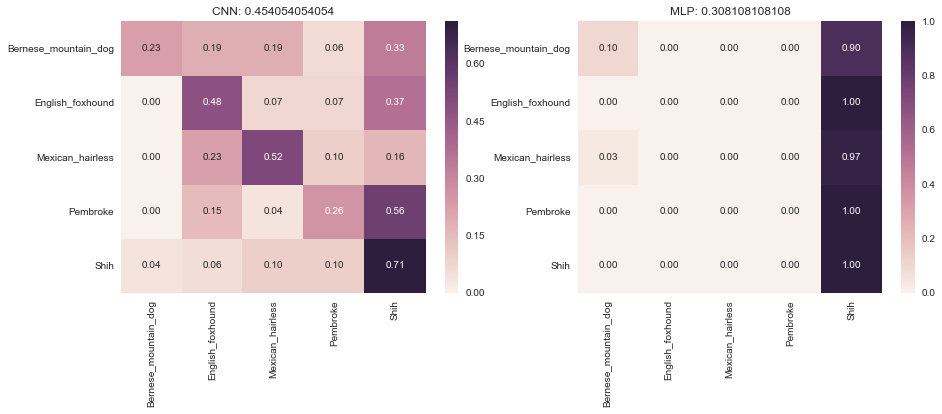

In [11]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

In [12]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from keras.applications.resnet50 import preprocess_input, decode_predictions

keras.__version__

'2.0.9'

In [13]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
import os
import struct
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))



In [19]:
l2_lambda = 0.0001
img_hw = 128
X = np.expand_dims(X.reshape(-1,img_hw,img_hw), axis=3)
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

(740, 128, 128, 1)
(740,)


In [22]:
%%time

from keras.layers import average 
from keras.models import Input, Model

num_ensembles = 3

input_holder = Input(shape=(img_wh, img_wh, 1))

branches = []
for _ in range(num_ensembles):

    conv1 = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu')(input_holder)
    
    max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

    conv2 = Conv2D(filters=32,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu')(max1)
    
    max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


    # add one layer on flattened output
    drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
    flat1 = Flatten()(drop1)
    dense1 = Dense(128, 
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
                )(flat1)
    drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
    dense2 = Dense(NUM_CLASSES, 
                  activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(l2_lambda)
                 )(drop2)
    
    # now add this branch onto the master list
    branches.append(dense2)

# that's it, we just need to average the results
ave = average(branches)

# here is the secret sauce for setting the network using the 
#   Model API:
cnn_ens = Model(inputs=input_holder,outputs=ave)

# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=3, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/3
6/5 [====================================] - 75s 12s/step - loss: 2.1898 - acc: 0.1911 - val_loss: 1.7415 - val_acc: 0.1405
Epoch 2/3
6/5 [====================================] - 70s 12s/step - loss: 1.7334 - acc: 0.2125 - val_loss: 1.7031 - val_acc: 0.2595
Epoch 3/3
6/5 [====================================] - 79s 13s/step - loss: 1.7676 - acc: 0.1916 - val_loss: 1.7338 - val_acc: 0.1676
Wall time: 3min 46s


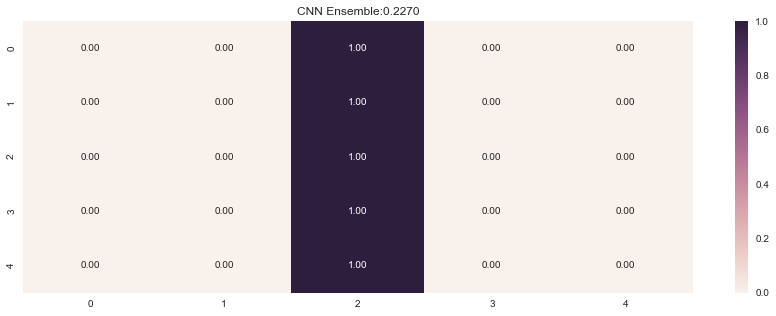

In [23]:
summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')